# Unsupervised image segmentation the old school way with Markov Fields

Simple example where we have a Potts MRF (prior) and three dimensional correlated Gaussian observations (conditional likelihood). We construct the posterior MRF to sample from and estimate the hiddens states.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
from jaxtyping import Float, Array
from sklearn.cluster import KMeans
import parametrization_cookbook.jax as pc

from mrfx.samplers import ChromaticGibbsSampler
from mrfx.models import AbstractMarkovRandomFieldModel, Potts, Gaussian
from mrfx.abstract import Params

from mrfx.estimators import StochasticExpectationMaximization, mpm_estimator

In [4]:
key = jax.random.PRNGKey(0)

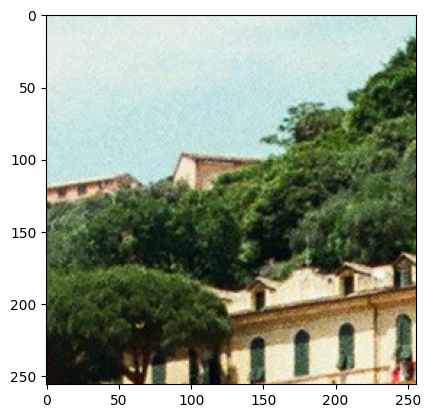

In [5]:
Y = plt.imread("grigorii-shcheglov-YtULKNJ2BSM-unsplash_256x256.jpg") / 255
plt.imshow(Y)
plt.show()

Init with KMeans

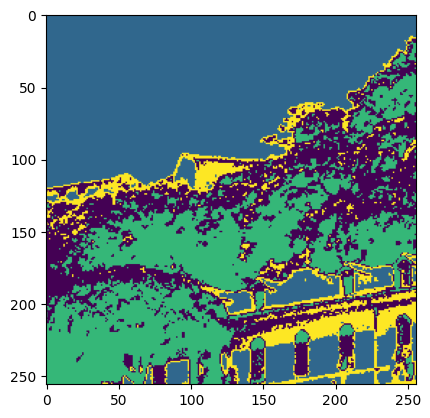

In [6]:
K = 4
lx = Y.shape[0]
ly = Y.shape[1]
kmeans_seg = KMeans(n_clusters=K).fit(Y.reshape((-1, 3))).labels_.reshape((lx, ly))
kmeans_seg = jnp.array(kmeans_seg)
plt.imshow(kmeans_seg)
plt.show()

In [7]:
sem = StochasticExpectationMaximization(eps=1e-5, max_iter=30, verbose=True)

In [8]:
# random init for models and their parameters
key, subkey = jax.random.split(key, 2)
vreals = jax.random.uniform(subkey, minval=-3, maxval=3, shape=(6,))
parametrization = pc.MatrixSymPosDef(dim=3)
# cov_init = jnp.array([parametrization.reals1d_to_params(vreals) for i in range(3)])

cov_init = parametrization.reals1d_to_params(vreals)
mu_init = 0.1 * jnp.ones((K, 3))
beta_init = 0.1

potts_model = Potts(K=K, beta=beta_init)
cond_llkh = Gaussian(
    dim=3,
    mu=mu_init,
    cov=cov_init,
    prior_model=potts_model,
)


class PosteriorFieldParameters(Params):
    beta: Float
    mu: Array
    cov: Array


class PosteriorField(AbstractMarkovRandomFieldModel):
    """ """

    K: int = eqx.field(kw_only=True, static=True)
    neigh_size: int = eqx.field(kw_only=True, static=True, default=1)
    params: PosteriorFieldParameters = eqx.field(kw_only=True)
    Y: Array = eqx.field(kw_only=True)

    def potential(self, x: Array, neigh_values: Array, u: Array, v: Array) -> Float:
        return self.params.beta * (x == neigh_values).sum(
            dtype=neigh_values.dtype
        ) + jax.scipy.stats.multivariate_normal.logpdf(
            self.Y[u, v],
            self.params.mu[x],
            self.params.cov,  # [x]
        )


params = PosteriorFieldParameters(beta=beta_init, mu=mu_init, cov=cov_init)
post_field = PosteriorField(K=K, params=params, Y=Y)

# init the sampler
chro_gibbs = ChromaticGibbsSampler(
    lx=lx, ly=ly, eps=0.05, max_iter=1000, color_update_type="sequential_in_color"
)

potts_model, cond_llkh, post_field = sem.run(
    potts_model, cond_llkh, post_field, chro_gibbs, kmeans_seg, Y, key=subkey
)

Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 0
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 1
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 2
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 3
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 4
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 5
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 6
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 7
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 8
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 9
Stopping chromatic Gibbs sampler, cause: Convergence criterion is reached
SEM iteration 10
Stopping 

In [9]:
key, subkey = jax.random.split(key, 2)
X_MPM = mpm_estimator(chro_gibbs, post_field, K, 10, subkey)

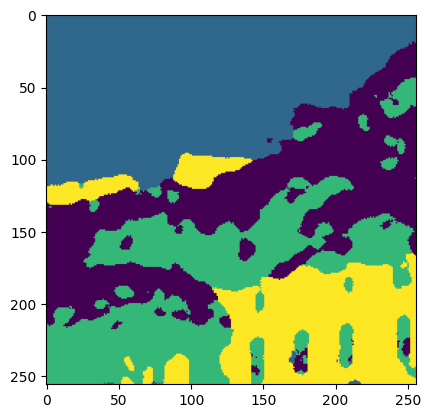

In [10]:
plt.imshow(X_MPM)
plt.show()

In [11]:
print(cond_llkh.params.mu, potts_model.params.beta)

[[0.28561217 0.36808494 0.19876955]
 [0.7995994  0.8953062  0.87974125]
 [0.14188929 0.17386068 0.10393085]
 [0.70309764 0.6261566  0.48819166]] 3.014272


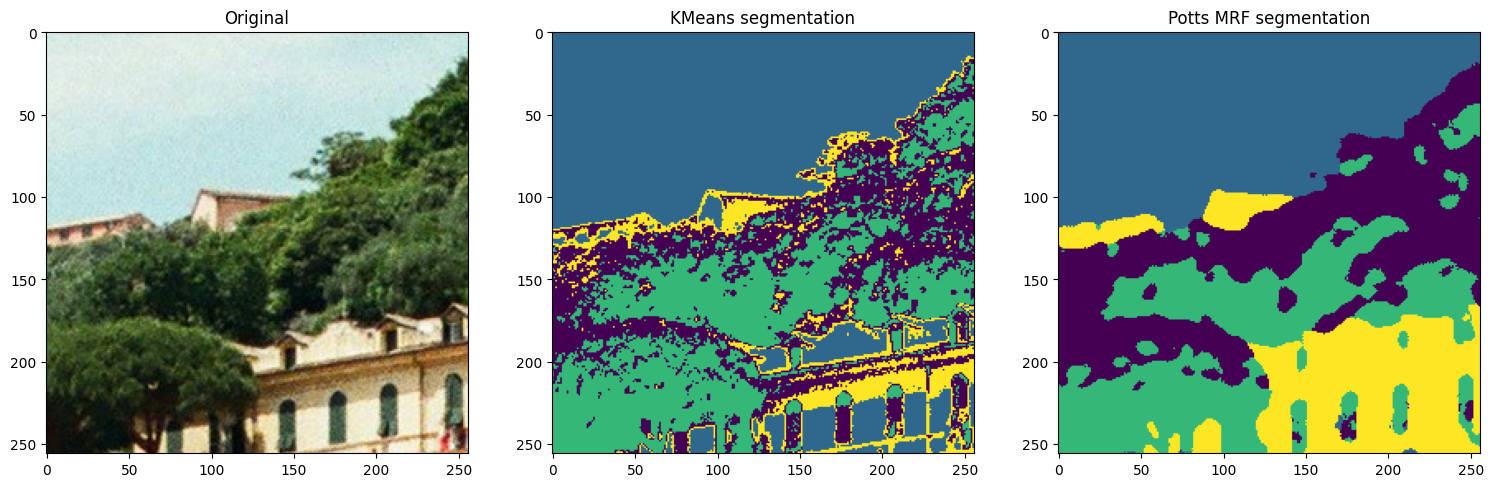

In [15]:
# fig, axes = plt.subplots(1, 3)
# fig.set_size_inches(18.5, 10.5)
# axes[0].imshow(Y)
# axes[0].set_title("Original")
# axes[1].imshow(kmeans_seg)
# axes[1].set_title("KMeans segmentation")
# axes[2].imshow(X_MPM)
# axes[2].set_title("Potts MRF segmentation")
# fig.savefig('real_example_segmentation.png', dpi=fig.dpi, bbox_inches='tight')
# plt.show()